# **vegetable-image-classification-with-pytorch CNN**

# **Introduction**

Convolutional Neural Networks (CNNs) have emerged as powerful tools for image classification tasks, offering remarkable performance in various domains including agriculture. In this context, the application of CNNs to vegetable image classification, where images are categorized into different classes based on vegetable types, holds significant potential.

With a dataset comprising 21,000 images distributed across 15 distinct classes representing different types of vegetables, CNNs offer a promising avenue for automating the classification process. Leveraging the inherent ability of CNNs to automatically learn relevant features from raw pixel data, these models can discern intricate patterns and characteristics unique to each vegetable class, facilitating accurate classification.

The utilization of CNNs in vegetable image classification not only streamlines the categorization process but also holds practical implications in agriculture and food industry automation. By enabling rapid and accurate identification of vegetables, CNN-based classification systems can aid farmers, distributors, and retailers in quality control, inventory management, and product traceability.

# **Aim**

Through this study, we aim to explore the efficacy of CNNs in vegetable image classification, leveraging a sizable dataset to train robust models capable of accurately categorizing vegetables across multiple classes. Our findings contribute to the advancement of computer vision techniques in agricultural applications, fostering efficiency, and precision in vegetable classification processes.



# **Data Pre Processing**

**Importing Libraries**

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# **Downloadng Dataset**

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/misrakahmed/vegetable-image-dataset'
od.download(dataset_url)

100%|██████████| 534M/534M [00:08<00:00, 69.9MB/s]


# **Dataset Exploration**

Before exploring the downloaded dataset, it must be stored in data directory.Storing dataset paths in variables within a designated data directory enhances code organization, readability, flexibility, portability, scalability, and collaboration, making the development process smoother and more efficient.

In [ ]:
DATA_DIR = '/content/vegetable-image-dataset/Vegetable Images'

**Checking the number of classes that dataset contain**

In [ ]:
classes = len(os.listdir(DATA_DIR + '/train'))
classes

15

**Determinng the number of Images that the train set/validation set/training set have.**

To determine the number of training images, you can multiply the number of images per class by the number of classes. The same approach can be used to calculate the number of images for test and validation sets.

In [ ]:
trainImages = len(os.listdir(DATA_DIR + '/train/Cabbage')) * classes
trainImages

15000

In [ ]:
testImages = len(os.listdir(DATA_DIR + '/test/Cabbage')) * classes
testImages

3000

In [ ]:
valImages = len(os.listdir(DATA_DIR + '/validation/Cabbage')) * classes
valImages

3000

In [ ]:
print(f"There are {trainImages} images for training, {testImages} for testing and {valImages} for validation.")

There are 15000 images for training, 3000 for testing and 3000 for validation.


# **Data Transformation**

We'll define transformations for processing images. Initially, we'll randomly flip images horizontally, convert them into tensors, and normalize them based on predefined statistics. Additionally, we'll resize the images to a uniform size of 100x100 pixels to ensure consistency across all images. For validation and testing, we'll perform all these steps except for the random horizontal flips.

In [ ]:
trainTfms = tt.Compose([ tt.RandomCrop(100, padding=4, padding_mode='reflect'),
                         tt.Resize((100,100), antialias=False),
                         tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                       ] )
validTestTfms = tt.Compose([tt.ToTensor(), tt.Resize((100,100), antialias=False),])

**Creating the Dataset using Image Folder**

 ImageFolder class from PyTorch allows us to load datasets where the directory structure represents class labels.



In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
train_ds = ImageFolder(DATA_DIR + '/train', trainTfms)
test_ds = ImageFolder(DATA_DIR + '/test', validTestTfms)
valid_ds = ImageFolder(DATA_DIR + '/validation', validTestTfms)

**Setting the batch size**

A batch size of 64 is selected to optimize computational efficiency and gradient accuracy during training, balancing the simultaneous processing of samples with memory constraints.

In [ ]:
batchSize = 64

**Creatng dataLoaders**

Creating dataloaders is crucial as they streamline the process of loading data in batches, enabling efficient training, validation, and testing of machine learning models by automatically handling data shuffling, batching, and parallel processing.

In [ ]:
train_dl = DataLoader(train_ds, batchSize, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batchSize*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batchSize*2, num_workers=2, pin_memory=True)

# **Visualizing the Images of the classes**

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=11).permute(1, 2, 0))
        break

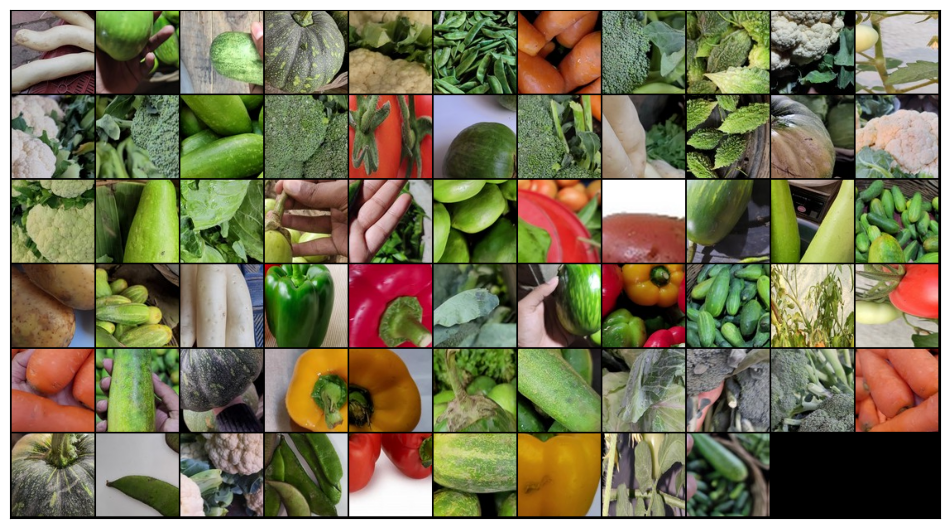

In [ ]:
show_batch(train_dl)

# **Accessing GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

This code will automatically use the GPU if it's available and fall back to the CPU otherwise. It ensures that your objects are placed on the appropriate device for computation.

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl , device)
valid_dl = DeviceDataLoader(valid_dl , device)
test_dl = DeviceDataLoader(test_dl, device)

# **Model Configuration**

**Establishing Accuracy function and Image base class.**

Both functions are universal and do not necessitate alterations irrespective of the datasets. They serve as auxiliary functions to compute accuracy and apply loss function for determining the training and validation loss of the model.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# **Model Architecture**

In [ ]:
class VegetableImageDatasetCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16 X 50 X 50

            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 X 25 X 25

            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, 5), # 64 X 5 X 5

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64*5*5, 15))

    def forward(self, xb):
      return self.network(xb)

In [ ]:
model = VegetableImageDatasetCnnModel()
model

VegetableImageDatasetCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.3, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=1600, out_features=15,

# **Model Optimization using Evaluate & Fit Function**

We'll define two essential functions: fit and evaluate, to facilitate the training and evaluation of our model. The fit function will handle the training process using gradient descent, optimizing the model's parameters based on the training data. Meanwhile, the evaluate function will assess the model's performance on the validation set, providing valuable insights into its generalization capabilities.

In [ ]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#checking how the model performs on validation set with initial set of parameters
model = to_device(VegetableImageDatasetCnnModel(), device)


The model's performance appears to be quite poor prior to training. As observed, the accuracy of the model is less than 1%, indicating that the model is essentially making random guesses for the output.

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.7106919288635254, 'val_acc': 0.0647786483168602}]

# **Training the model and Result Analysis**


**Configuring the parameters before commencing training.**

In [ ]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

**Running the model for 5 epochs**

In [ ]:
%%time

os.environ['WANDB_CONSOLE'] = 'off'

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 1.7673, val_loss: 3.1107, val_acc: 0.2804
Epoch [1], train_loss: 1.1589, val_loss: 1.3909, val_acc: 0.5405
Epoch [2], train_loss: 0.8637, val_loss: 1.0176, val_acc: 0.6553
Epoch [3], train_loss: 0.6834, val_loss: 0.5454, val_acc: 0.8189
Epoch [4], train_loss: 0.5441, val_loss: 0.5705, val_acc: 0.8175
CPU times: user 11.2 s, sys: 4.92 s, total: 16.2 s
Wall time: 1min 55s


The model has achieved accuracy of 82 % on validation set which is fairly good. It took 5 minutes to run five epochs.

# **Accuracy vs No of epochs**

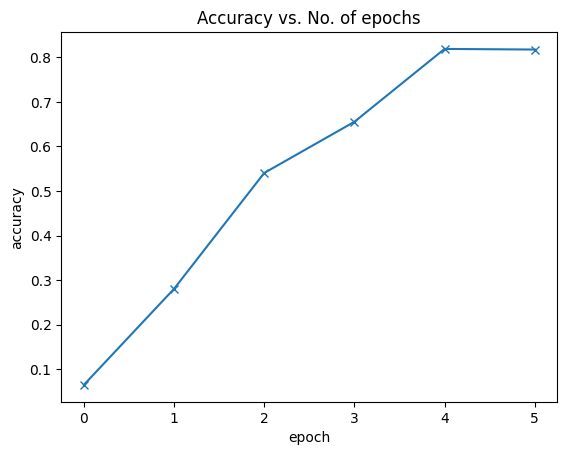

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

# **Loss vs epochs**

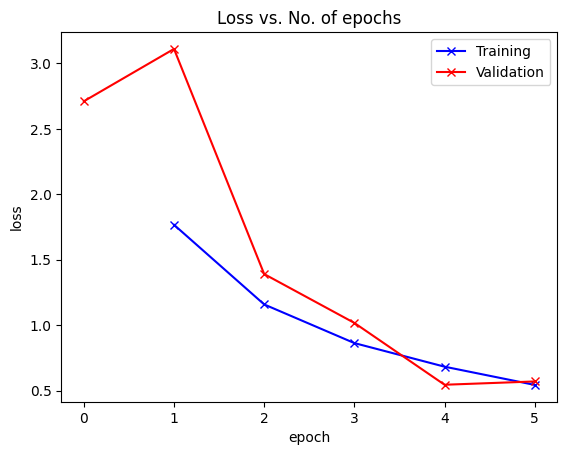

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Training and Validaton losses are not  diverging that much hence this shows that there is less overfitting in the model.

# **Learning rate with batch no**

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

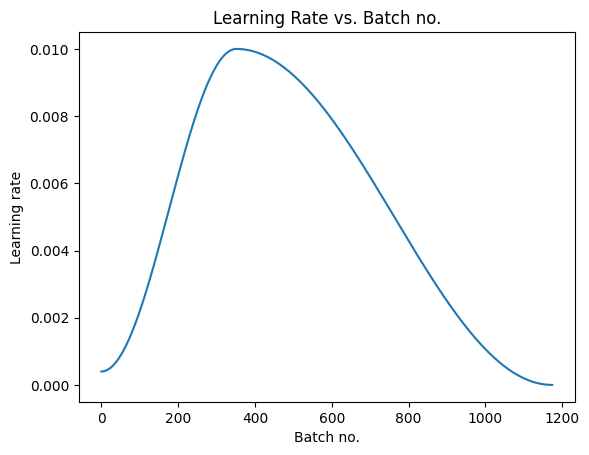

In [ ]:
plot_lrs(history)


# **Predictions**

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_ds.classes[preds[0].item()]

Label: Bean , Predicted: Bean


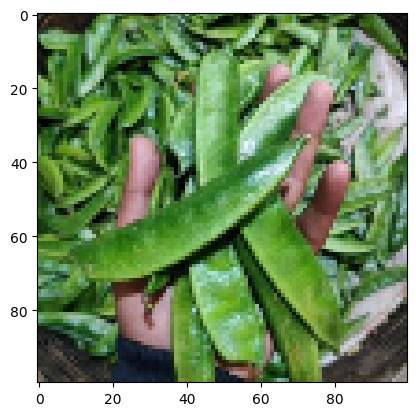

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Carrot , Predicted: Carrot


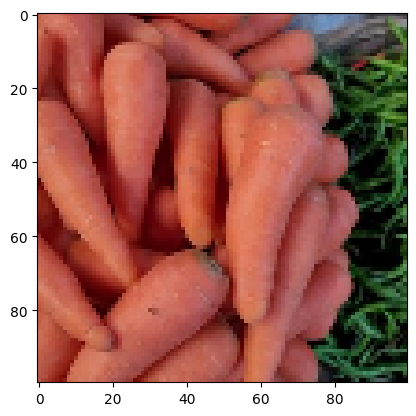

In [ ]:
img, label = test_ds[1500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Bottle_Gourd , Predicted: Bottle_Gourd


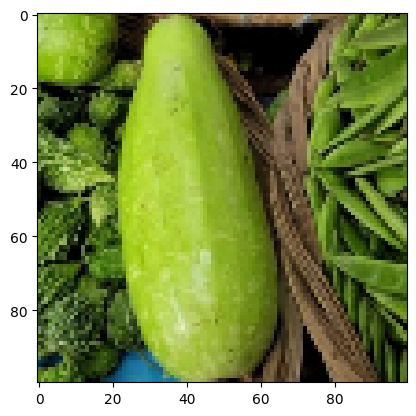

In [ ]:
img, label = test_ds[400]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

# **Overall loss and accuracy of the model on the test set**

In [ ]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.558046817779541, 'val_acc': 0.8241722583770752}

In [ ]:
!pip install jovian --upgrade -q
import jovian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Metrics logged.


# **Saving the Model**

In [ ]:
torch.save(model.state_dict(), 'vegetables-Image-Classification.pth')


The .state_dict method yields an OrderedDict comprising all weight and bias matrices, appropriately mapped to the corresponding attributes of the model. To load the model weights, we can redefine the model with identical structure and utilize the .load_state_dict method.

In [ ]:
model2 = to_device(VegetableImageDatasetCnnModel(), device)

In [ ]:
model2.load_state_dict(torch.load('vegetables-Image-Classification.pth'))

<All keys matched successfully>

As a sanity check, let's ensure that this model achieves the same loss and accuracy on the test set as it did previously.

In [ ]:
evaluate(model2, test_dl)

{'val_loss': 0.558046817779541, 'val_acc': 0.8241722583770752}

# **Future Works**

For future work, several avenues can be explored to enhance the performance and applicability of the model. Specifically, comparisons with more advanced architectures such as ResNet-9 and exploration of transfer learning techniques can provide valuable insights into further improving classification accuracy and generalization capabilities. Additionally, deploying the model on the web can extend its accessibility and usability, allowing users to leverage its capabilities remotely for various tasks. These endeavors can collectively contribute to advancing the effectiveness and accessibility of the model for vegetable image classification tasks.

# **Summary**

The model has demonstrated significant success, achieving an impressive 81% accuracy on the test dataset. This performance underscores the effectiveness of the CNN-based approach in accurately classifying vegetable images. The achieved accuracy signifies the model's capability to discern intricate patterns and features characteristic of different vegetable types. With this level of accuracy, the model holds promise for various practical applications in agriculture, including quality control, inventory management, and product classification. Moreover, the success of the model opens avenues for further refinement and exploration, potentially leading to even higher accuracies and broader deployment in real-world scenarios. Overall, the achieved 81% accuracy marks a substantial milestone, showcasing the model's proficiency in vegetable image classification tasks.

# **References**

https://jovian.com/hargurjeet/fruit-360-classification-v1-2204a:

https://jovian.com/gustavoriveram/classifying-fruits-and-vegetables

https://jovian.com/abdulzain6/vegetable-multiclass-classification

# **Saving and Uploading the Notebook**

In [ ]:
jovian.commit(project='Vegetable Classification with CNN')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
